In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# !unzip -q "/content/gdrive/My Drive/Colab Notebooks/eip/data/hvc_data.zip" -d "/content/gdrive/My Drive/Colab Notebooks/eip/data/hvc_data"
# look for `hvc_annotations.csv` file and `resized` dir
%ls "/content/gdrive/My Drive/Colab Notebooks/eip/data/hvc_data/resized" | wc 

  13573   13573  124624


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt

from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet import ResNet50, ResNet101, ResNet152
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2

Using TensorFlow backend.


In [0]:
# load annotations
gdrive_eip_path = "/content/gdrive/My Drive/Colab Notebooks/eip/"
data_path = gdrive_eip_path+"data/hvc_data/"
df = pd.read_csv(data_path+"hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)



In [0]:
one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation = None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(data_path+item["image_path"]) for _, item in items.iterrows()])
        if self.augmentation is not None:
          image = self.augmentation.flow(image, shuffle=False).next()
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=42) # answer to life, meaning and everything
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
10416,resized/10418.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
3495,resized/3496.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0
6950,resized/6951.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
5035,resized/5036.jpg,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
4410,resized/4411.jpg,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1


In [0]:
val_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
749,resized/750.jpg,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
8910,resized/8911.jpg,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1
11703,resized/11705.jpg,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1
2980,resized/2981.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
4890,resized/4891.jpg,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0


In [0]:
# Image Augumentation
image_aug = ImageDataGenerator(
    rotation_range=10,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    channel_shift_range=20,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=True,
    # set function that will be applied on each input
    preprocessing_function=None,
    )

In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32, augmentation=image_aug)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
# backbone = VGG16(
#     weights="imagenet", 
#     include_top=False, 
#     input_tensor=Input(shape=(224, 224, 3))
# )

model_type = 'ResNet50V2'

backbone = ResNet50V2(
    weights=None,
    include_top = False,
    input_tensor = Input(shape=(224,224,3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Callbacks

# Prepare model model saving directory.
model_save_dir = gdrive_eip_path+'assign5/saved_models'
model_name = 'assign5_%s_model.{epoch:03d}.h5' % model_type
model_file_path = model_save_dir + model_name

class_names = [            
               "gender_output",
               "image_quality_output",
               "age_output",
               "weight_output",
               "bag_output",
               "footwear_output",
               "pose_output",
               "emotion_output"
               ]

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=model_file_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr_rates = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.08, 0.1]
    lr = lr_rates[int(epoch%8)]

    # lr = 0.001
    # if epoch > 20:
    #     lr = 0.0001
    # elif epoch > 35:
    #     lr = 0.00005
    # elif epoch > 50:
    #     lr = 0.00001
    # elif epoch > 65:
    #     lr = 0.000005
    # elif epoch > 80:
    #     lr = 0.000001
    # elif epoch > 95:
    #     lr = 0.0000005
    # elif epoch > 110:
    #     lr = 0.0000001
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

callbacks = [checkpoint, lr_scheduler ]



In [0]:
# freeze backbone
for layer in backbone.layers:
	layer.trainable = True

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}
opt = SGD(lr= 0.01, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

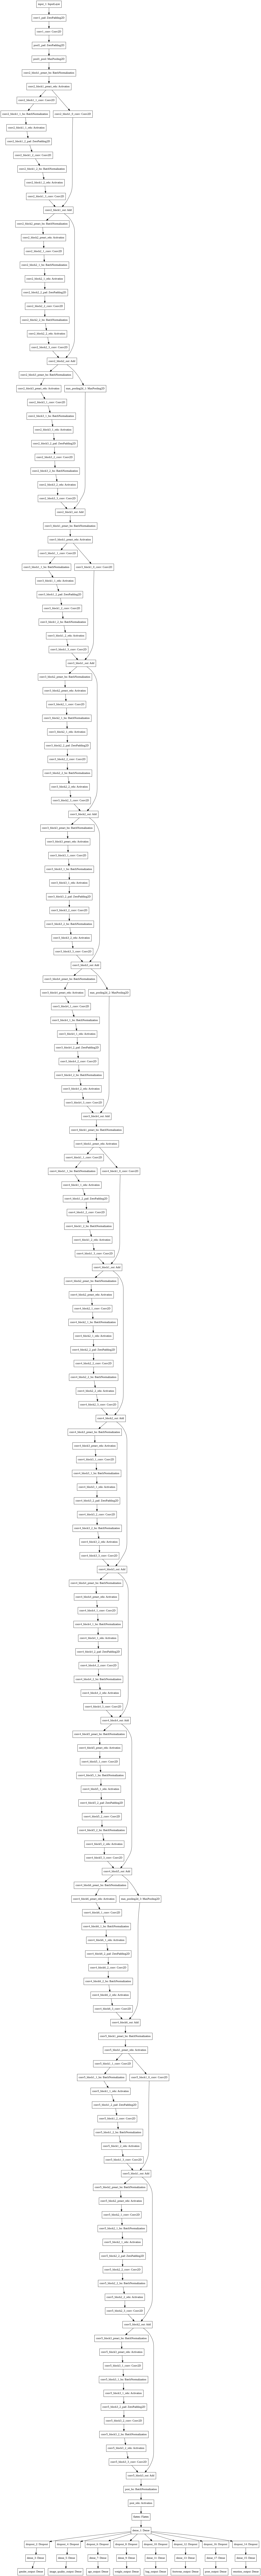

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
# model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=10)

In [0]:
model_history = model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=10,
    verbose=1,
    callbacks= callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
Learning rate:  1e-06
360/360 [==============================] - 688s 2s/step - loss: 9.3675 - gender_output_loss: 0.7724 - image_quality_output_loss: 1.1290 - age_output_loss: 1.7113 - weight_output_loss: 1.1538 - bag_output_loss: 1.0361 - footwear_output_loss: 1.2374 - pose_output_loss: 1.2580 - emotion_output_loss: 1.0696 - gender_output_acc: 0.5210 - image_quality_output_acc: 0.4703 - age_output_acc: 0.2673 - weight_output_acc: 0.5702 - bag_output_acc: 0.4888 - footwear_output_acc: 0.3447 - pose_output_acc: 0.4036 - emotion_output_acc: 0.6596 - val_loss: 8.5252 - val_gender_output_loss: 0.7442 - val_image_quality_output_loss: 1.0582 - val_age_output_loss: 1.5527 - val_weight_output_loss: 1.0677 - val_bag_output_loss: 0.9978 - val_footwear_output_loss: 1.0926 - val_pose_output_loss: 0.9991 - val_emotion_output_loss: 1.0130 - val_gender_output_acc: 0.5257 - val_image_quality_out

In [0]:
def plot_model_history(model_history):
    # fig, axs = plt.subplots(1,2,figsize=(15,5))
    # # summarize history for accuracy
    # axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    # axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    # axs[0].set_title('Model Accuracy')
    # axs[0].set_ylabel('Accuracy')
    # axs[0].set_xlabel('Epoch')
    # axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    # axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    # axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    # axs[1].set_title('Model Loss')
    # axs[1].set_ylabel('Loss')
    # axs[1].set_xlabel('Epoch')
    # axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    # axs[1].legend(['train', 'val'], loc='best')
    # plt.show()

In [0]:
# plot model history
plot_model_history(model_history)

TypeError: ignored

In [0]:
# Score trained model.
scores = model.evaluate(valid_gen, verbose=1)[1:]

In [0]:
loss_values = {class_names[i]+'_loss': scores[i] for i in range(len(class_names))}
acc_values = {class_names[i]+'_acc': scores[i+8] for i in range(len(class_names))}
print(loss_values)
print(acc_values)